In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

n = 3000
start = datetime(2025, 1, 1)
users = [f'u{100000 + i}' for i in range(n)]
rows = []
np.random.seed(1)

for u in users:
    signup = start + timedelta(days=np.random.randint(0,120))
    treatment = np.random.choice([0,1], p=[0.5,0.5])
    rows.append({'user_id':u,'event_name':'signup','event_time':signup.isoformat(), 'treatment':treatment})
    # activation within 14 days 60%
    if np.random.rand() < 0.6:
        ro = signup + timedelta(days=np.random.randint(0,14))
        rows.append({'user_id':u,'event_name':'activate','event_time':ro.isoformat(), 'treatment':treatment})
    # first_deposit 25%
    if np.random.rand() < 0.25:
        rd = signup + timedelta(days=np.random.randint(1,90))
        rows.append({'user_id':u,'event_name':'first_deposit','event_time':rd.isoformat(), 'treatment':treatment})
df = pd.DataFrame(rows)
df.to_csv('events.csv', index=False)
print('wrote events.csv with', len(df), 'rows')


wrote events.csv with 5584 rows


In [3]:
df = pd.read_csv('events.csv', parse_dates=['event_time'])

In [4]:
first = df[df.event_name=='signup'].groupby('user_id', as_index=False).agg({'event_time':'min'}).rename(columns={'event_time':'signup_time'})

In [5]:
merged = df.merge(first, on='user_id', how='inner')
merged['days_after_signup'] = (merged['event_time'] - merged['signup_time']).dt.days
funnel_events = merged[(merged['days_after_signup'] >= 0) & (merged['days_after_signup'] <= 14) & (merged['event_name'].isin(['signup','activate','first_deposit']))]
funnel_counts = funnel_events.groupby('event_name')['user_id'].nunique().reset_index().rename(columns={'user_id':'users'})
print(funnel_counts)

      event_name  users
0       activate   1777
1  first_deposit    116
2         signup   3000


In [6]:
merged['cohort_week'] = merged['signup_time'].dt.to_period('W').apply(lambda r: r.start_time)
merged['event_week'] = merged['event_time'].dt.to_period('W').apply(lambda r: r.start_time)
cohort = merged.groupby(['cohort_week','event_week']).agg(users=('user_id','nunique')).reset_index()
cohort['week_num'] = ((cohort['event_week'] - cohort['cohort_week']).dt.days // 7).astype(int)
pivot = cohort.pivot_table(index='cohort_week', columns='week_num', values='users').fillna(0)
print(pivot.head())


week_num        0     1     2    3    4    5    6    7    8    9    10   11  \
cohort_week                                                                   
2024-12-30   132.0  36.0  23.0  4.0  1.0  2.0  8.0  2.0  3.0  5.0  0.0  3.0   
2025-01-06   166.0  43.0  17.0  1.0  7.0  4.0  2.0  0.0  5.0  3.0  6.0  2.0   
2025-01-13   171.0  51.0  30.0  2.0  4.0  4.0  6.0  3.0  4.0  4.0  2.0  6.0   
2025-01-20   174.0  48.0  34.0  2.0  4.0  2.0  0.0  1.0  5.0  2.0  4.0  1.0   
2025-01-27   180.0  65.0  26.0  4.0  3.0  4.0  4.0  2.0  4.0  5.0  3.0  2.0   

week_num      12   13  
cohort_week            
2024-12-30   3.0  3.0  
2025-01-06   2.0  2.0  
2025-01-13   6.0  1.0  
2025-01-20   2.0  2.0  
2025-01-27   3.0  1.0  


In [7]:
# compute users with first_deposit in windows
df2 = merged[merged['event_name']=='first_deposit'].copy()
df2['days_after_signup'] = (df2['event_time'] - df2['signup_time']).dt.days
def assign_window(d):
    if d <= 7: return '0-7'
    elif d <= 30: return '8-30'
    else: return '31+'
df2['win'] = df2['days_after_signup'].apply(assign_window)
win = df2.groupby(['treatment','win'])['user_id'].nunique().reset_index()
print(win)


   treatment   win  user_id
0          0   0-7       29
1          0   31+      263
2          0  8-30      102
3          1   0-7       32
4          1   31+      285
5          1  8-30       96


In [8]:
#  whether they had first_deposit within 30 days
users = merged.groupby('user_id').agg({'signup_time':'first','treatment':'first'})
users = users.reset_index()
# has_deposit_30: 1 if first_deposit within 30 days
deposits = merged[merged['event_name']=='first_deposit']
deposits_30 = deposits[deposits['days_after_signup'] <= 30].groupby('user_id')['event_name'].count().reset_index().rename(columns={'event_name':'deposits_30'})
users = users.merge(deposits_30, on='user_id', how='left').fillna(0)
users['deposits_30'] = (users['deposits_30']>0).astype(int)

# logistic regression with treatment as predictor 
import statsmodels.formula.api as smf
users['treatment'] = users['treatment'].astype(int)
model = smf.logit('deposits_30 ~ treatment', data=users).fit(disp=False)
print(model.summary())



                           Logit Regression Results                           
Dep. Variable:            deposits_30   No. Observations:                 3000
Model:                          Logit   Df Residuals:                     2998
Method:                           MLE   Df Model:                            1
Date:                Wed, 27 Aug 2025   Pseudo R-squ.:               5.010e-06
Time:                        02:25:04   Log-Likelihood:                -881.91
converged:                       True   LL-Null:                       -881.91
Covariance Type:            nonrobust   LLR p-value:                    0.9251
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.3532      0.091    -25.738      0.000      -2.532      -2.174
treatment     -0.0122      0.130     -0.094      0.925      -0.267       0.243


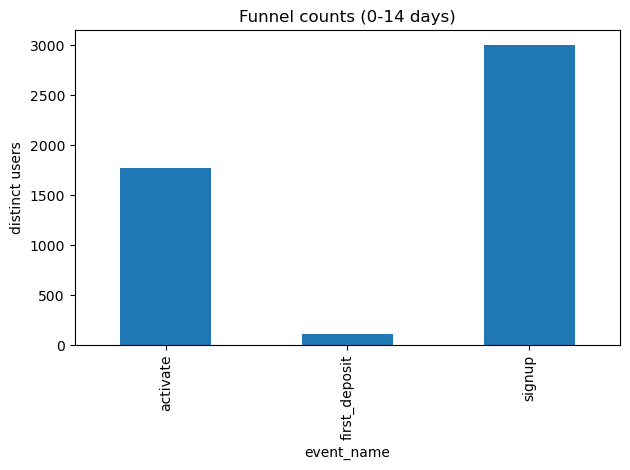

In [10]:
import matplotlib.pyplot as plt
# bar chart for funnel counts
funnel_counts.plot.bar(x='event_name', y='users', legend=False)
plt.title('Funnel counts (0-14 days)')
plt.ylabel('distinct users')
plt.tight_layout()
plt.savefig('one_page_readout.png', dpi=200)


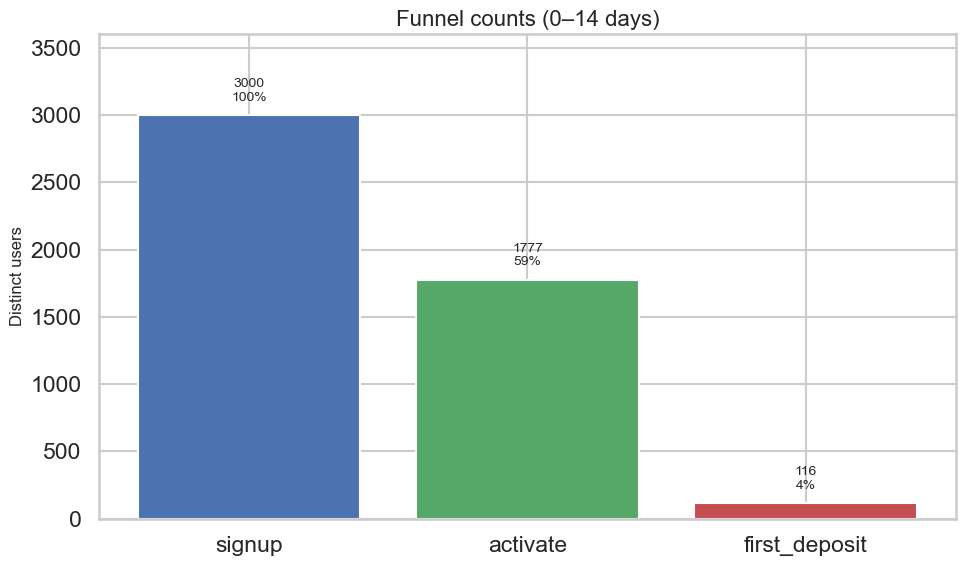

In [21]:
# Funnel counts plot 
import seaborn as sns

#  funnel_counts if missing
if 'funnel_counts' not in globals():
    if 'funnel_events' in globals():
        funnel_counts = funnel_events.groupby('event_name')['user_id'].nunique().reset_index().rename(columns={'user_id':'users'})
    elif 'merged' in globals():
        temp = merged[(merged['days_after_signup'] >= 0) & (merged['days_after_signup'] <= 14) & (merged['event_name'].isin(['signup','activate','first_deposit']))]
        funnel_counts = temp.groupby('event_name')['user_id'].nunique().reset_index().rename(columns={'user_id':'users'})
    else:
        raise RuntimeError("funnel_counts not found and couldn't be computed. Create funnel_events or run the funnel steps first.")

# Order steps if present
step_order = ['signup', 'activate', 'first_deposit']
funnel_counts['event_name'] = pd.Categorical(funnel_counts['event_name'], categories=step_order, ordered=True)
fplot = funnel_counts.sort_values('event_name')

# Plot
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
bars = plt.bar(fplot['event_name'].astype(str), fplot['users'], color=['#4C72B0','#55A868','#C44E52'])
plt.title('Funnel counts (0–14 days)', fontsize=16)
plt.ylabel('Distinct users', fontsize=12)
plt.ylim(0, fplot['users'].max()*1.2)

# annotate counts and conversion %
total = fplot.loc[fplot['event_name']=='signup','users'].values
if total.size>0 and total[0]>0:
    total = total[0]
    for rect, users in zip(bars, fplot['users']):
        pct = users/total * 100
        plt.annotate(f"{int(users)}\n{pct:.0f}%", xy=(rect.get_x() + rect.get_width() / 2, rect.get_height()),
                     xytext=(0,8), textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('funnel_counts.png', dpi=200, bbox_inches='tight')
plt.show()


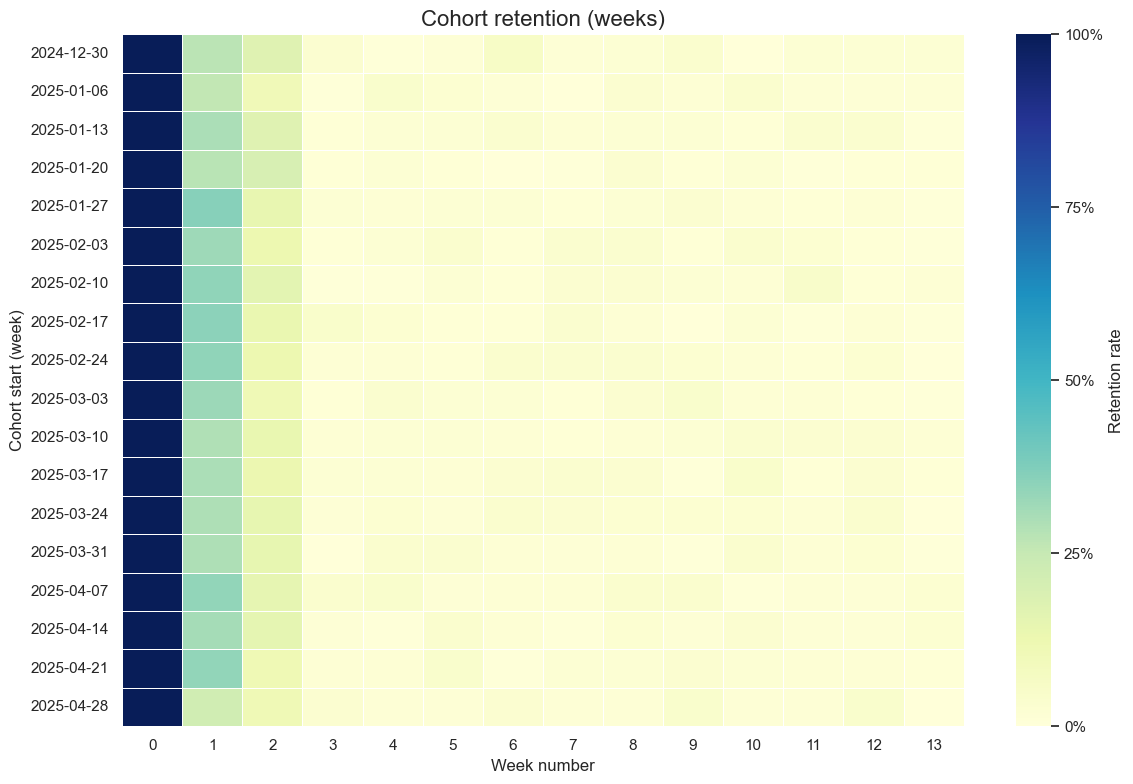

In [23]:
# Cohort retention heatmap
# pivot if missing (pivot: index=cohort_week, cols=week_num -> users)
if 'pivot' not in globals():
    if 'merged' in globals():
        merged['cohort_week'] = pd.to_datetime(merged['signup_time']).dt.to_period('W').apply(lambda r: r.start_time)
        merged['event_week'] = pd.to_datetime(merged['event_time']).dt.to_period('W').apply(lambda r: r.start_time)
        cohort = merged[(merged['event_time'] >= merged['signup_time']) & (merged['event_time'] <= merged['signup_time'] + pd.Timedelta(days=90))]
        cohort = cohort.groupby(['cohort_week','event_week']).agg(users=('user_id','nunique')).reset_index()
        cohort['week_num'] = ((cohort['event_week'] - cohort['cohort_week']).dt.days // 7).astype(int)
        pivot = cohort.pivot_table(index='cohort_week', columns='week_num', values='users').fillna(0)
    else:
        raise RuntimeError("pivot not found and couldn't be computed. Run cohort prep steps first.")

# Convert counts to retention rates (divide by cohort week-0)
cohort_rates = pivot.div(pivot.iloc[:,0].replace(0, np.nan), axis=0).fillna(0)

# Plot
plt.figure(figsize=(12,8))
sns.set(font_scale=1.0)
# Convert index to strings for nicer labels
heat_df = cohort_rates.copy()
heat_df.index = heat_df.index.astype(str)
ax = sns.heatmap(heat_df, cmap='YlGnBu', linewidths=0.5, linecolor='white', cbar_kws={'label':'Retention rate'}, vmax=1.0)
ax.set_title('Cohort retention (weeks)', fontsize=16)
ax.set_xlabel('Week number', fontsize=12)
ax.set_ylabel('Cohort start (week)', fontsize=12)
# format colorbar ticks as %
cbar = ax.collections[0].colorbar
cbar.set_ticks([0,0.25,0.5,0.75,1.0])
cbar.set_ticklabels(['0%','25%','50%','75%','100%'])
plt.tight_layout()
plt.savefig('cohort_retention.png', dpi=200, bbox_inches='tight')
plt.show()

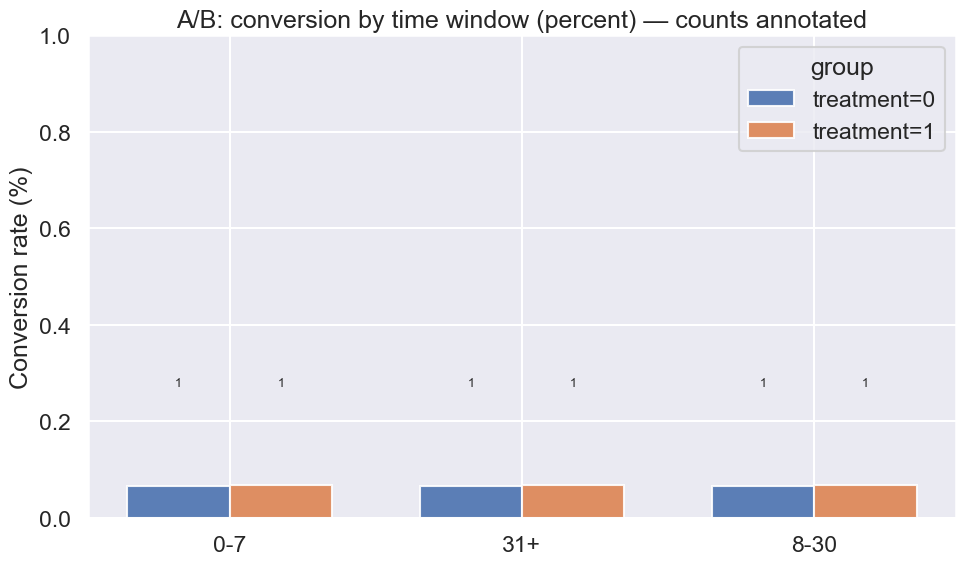

In [33]:
# A/B conversion by time window
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# should have columns treatment, win (0-7,8-30,31+), and count or user_id
if 'win' not in globals():
    if 'merged' in globals():
        deposits = merged[merged['event_name']=='first_deposit'].copy()
        if 'days_after_signup' not in deposits.columns:
            deposits['days_after_signup'] = (pd.to_datetime(deposits['event_time']) - pd.to_datetime(deposits['signup_time'])).dt.days
        def assign_window(d):
            if d <= 7: return '0-7'
            elif d <= 30: return '8-30'
            else: return '31+'
        deposits['win'] = deposits['days_after_signup'].apply(assign_window)
        win = deposits.groupby(['treatment','win'])['user_id'].nunique().reset_index().rename(columns={'user_id':'count'})
    else:
        raise RuntimeError("win not found and couldn't be computed. Run the A/B prep steps first.")

# Determine count column
if 'count' in win.columns:
    count_col = 'count'
elif 'users' in win.columns:
    count_col = 'users'
elif 'user_id' in win.columns:
    # aggregated by unique user count?
    win = win.groupby(['treatment','win'])['user_id'].nunique().reset_index().rename(columns={'user_id':'count'})
    count_col = 'count'
else:
    # try to find any numeric column
    numeric_cols = [c for c in win.columns if pd.api.types.is_numeric_dtype(win[c])]
    if numeric_cols:
        count_col = numeric_cols[0]
    else:
        raise RuntimeError("No numeric count column found in win. Columns: {}".format(list(win.columns)))    

# Use ab_counts and denom_series from diagnostics (recompute if needed)
ab_counts = win.pivot_table(index='treatment', columns='win', values='count' if 'count' in win.columns else win.columns[-1], aggfunc='sum', fill_value=0)
denom_series = merged.groupby('treatment')['user_id'].nunique() if 'merged' in globals() else ab_counts.sum(axis=1)
ab_rates = ab_counts.div(denom_series, axis=0)
wins_present = list(ab_rates.columns)

plt.figure(figsize=(10,6))
x = np.arange(len(wins_present))
width = 0.35
treatments = list(ab_rates.index)
for i, t in enumerate(treatments):
    rates = (ab_rates.loc[t, wins_present].values * 100)  # percent
    counts = ab_counts.loc[t, wins_present].values.astype(int)
    plt.bar(x + i*width, rates, width=width, label=f'treatment={t}', alpha=0.9)
    # annotate counts
    for xi, (r, c) in enumerate(zip(rates, counts)):
        plt.annotate(f"{c}", xy=(x[xi] + i*width, r + 0.2), ha='center', va='bottom', fontsize=9)

plt.xticks(x + width*(len(treatments)-1)/2, wins_present)
plt.ylabel('Conversion rate (%)')
plt.title('A/B: conversion by time window (percent) — counts annotated')
plt.legend(title='group')
plt.ylim(0, max((ab_rates.max().max()*100)*1.5, 1))
plt.tight_layout()
plt.savefig('ab_time_windows_pct.png', dpi=200, bbox_inches='tight')
plt.show()
